In [1]:
import Pkg
Pkg.add("SimpleCarModels")
Pkg.add("StaticArrays")
Pkg.activate(@__DIR__)
Pkg.instantiate()
# import MathOptInterface as MOI
# import Ipopt 
# import FiniteDiff
# import ForwardDiff
# import Convex as cvx 
# import ECOS
# using LinearAlgebra
using Plots
# using Random
# using JLD2
# using Test
# import MeshCat as mc 
import SimpleCarModels as scm
using StaticArrays

In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

**NOTE: This question will have long outputs for each cell, remember you can use `cell -> all output -> toggle scrolling` to better see it all**

## Q1: Direct Collocation (DIRCOL) for a Cart Pole (30 pts)

We are now going to start working with the NonLinear Program (NLP) Solver IPOPT to solve some trajectory optimization problems. First we will demonstrate how this works for simple optimization problems (not trajectory optimization). The interface that we have setup for IPOPT is the following:

$$ \begin{align} \min_{x} \quad & \ell(x) & \text{cost function}\\ 
 \text{st} \quad & c_{eq}(x) = 0 & \text{equality constraint}\\
 & c_L \leq c_{ineq}(x) \leq c_U & \text{inequality constraint}\\
 & x_L \leq x \leq x_U & \text{primal bound constraint}
 \end{align}$$
 
 where $\ell(x)$ is our objective function, $c_{eq}(x) = 0$ is our equality constraint, $c_L \leq c_{ineq}(x) \leq c_U$ is our bound inequality constraint, and $x_L \leq x \leq x_U $ is a bound constraint on our primal variable $x$. 
<!-- $$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$ -->

## Part A: Solve an LP with IPOPT (5 pts)
To demonstrate this, we are going to ask you to solve a simple Linear Program (LP):
 
 $$ \begin{align} \min_{x} \quad & q^Tx\\ 
 \text{st} \quad & Ax = b \\
 & Gx \leq h
 \end{align}$$
 
 Your job will be to transform this problem into the form shown above and solve it with IPOPT.  To help you interface with IPOPT, we have created a function `fmincon` for you. Below is the docstring for this function that details all of the inputs. 

In [3]:
"""
x = fmincon(cost,equality_constraint,inequality_constraint,x_l,x_u,c_l,c_u,x0,params,diff_type)

This function uses IPOPT to minimize an objective function 

`cost(params, x)` 

With the following three constraints: 

`equality_constraint(params, x) = 0`
`c_l <= inequality_constraint(params, x) <= c_u` 
`x_l <= x <= x_u` 

Note that the constraint functions should return vectors. 

Problem specific parameters should be loaded into params::NamedTuple (things like 
cost weights, dynamics parameters, etc.). 

args:
    cost::Function                    - objective function to be minimzed (returns scalar)
    equality_constraint::Function     - c_eq(params, x) == 0 
    inequality_constraint::Function   - c_l <= c_ineq(params, x) <= c_u 
    x_l::Vector                       - x_l <= x <= x_u 
    x_u::Vector                       - x_l <= x <= x_u 
    c_l::Vector                       - c_l <= c_ineq(params, x) <= x_u 
    c_u::Vector                       - c_l <= c_ineq(params, x) <= x_u 
    x0::Vector                        - initial guess 
    params::NamedTuple                - problem parameters for use in costs/constraints 
    diff_type::Symbol                 - :auto for ForwardDiff, :finite for FiniteDiff 
    verbose::Bool                     - true for IPOPT output, false for nothing 

optional args:
    tol                               - optimality tolerance 
    c_tol                             - constraint violation tolerance 
    max_iters                         - max iterations 
    verbose                           - verbosity of IPOPT 

outputs:
    x::Vector                         - solution 

You should try and use :auto for your `diff_type` first, and only use :finite if you 
absolutely cannot get ForwardDiff to work. 

This function will run a few basic checks before sending the problem off to IPOPT to 
solve. The outputs of these checks will be reported as the following:

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

If you're getting stuck during the testing of one of the derivatives, try switching 
to FiniteDiff.jl by setting diff_type = :finite. 
""";

In [4]:
# initial_state = scm.SE2State(0, 0, pi/2)
# goal_state = scm.SE2State(5, 0, pi/2)

# Tractor-Trailer Parameters
# g_tractor_wheelbase = 3.0
# g_tractor_hitch_offset = 0.5
# g_trailer_wheelbase = 6.0
# g_velocity = 0.5
# max_alpha = atan(g_tractor_wheelbase/sqrt((g_trailer_wheelbase^2) - (g_tractor_hitch_offset^2)))
# q_current = [0,0,pi/2, pi]
# r1 = g_tractor_wheelbase/tan(max_alpha);
# psi = -1*(max_alpha/abs(max_alpha))*atan(g_tractor_hitch_offset/abs(r1));
# va = (g_velocity/abs(g_velocity))*abs(((g_velocity*g_tractor_hitch_offset*tan(max_alpha))/(g_tractor_wheelbase*sin(psi))));
# vb = va*abs(cos(psi-q_current[4]));
# r2 = g_tractor_hitch_offset/sin(psi);
# max_turn_radius_eq = g_trailer_wheelbase/sin(psi-q_current[4]);

# print("Max turning radius from straight ahead to equillibrium is: ", max_turn_radius_eq)
# initial_state

# states = scm.reedsshepp_waypoints(initial_state, goal_state, 51, r=max_turn_radius_eq)
# traj_length = scm.reedsshepp_length(initial_state, goal_state)

# println("REEDS-SHEPP States: ")
# println(states)
# println("Length of optimal trajectory: ", length)

# for i=1:size(states)
    
# end

REEDS-SHEPP Path Length: 19.241676238045308
Item: [2.0, 1.0, 1.5707963267948966, 3.141592653589793, 0.0, 0.0]
Item: [1.9725268494747192, 2.9888134406326787, 1.5984222495372136, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [1.8901283638432975, 4.976109132070308, 1.6260481722795304, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [1.7528674249390592, 6.960370483377665, 1.6536740950218474, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [1.5608487824963069, 8.94008321925511, 1.6813000177641642, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [1.3142189742113777, 10.913736535647407, 1.7089259405064812, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [1.0131662139133457, 12.87982425270325, 1.736551863248798, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [0.6579202479299813, 14.836845964206095, 1.764177785991115, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [0.24875217975843178, 16.78330818259865, 1.7918037087334318, 3.141592653589793, 0.0, 7.6966704952181235]
Item: [-0

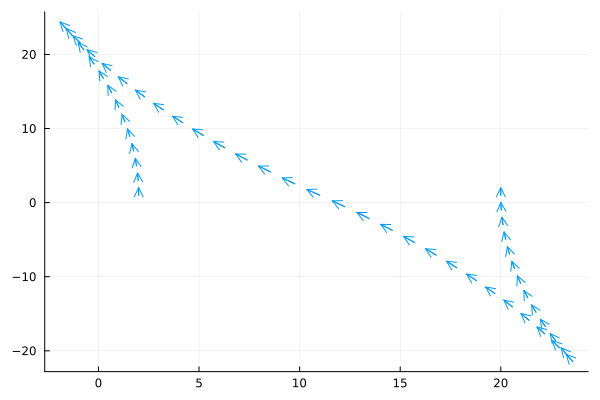

In [8]:
# Function to get the REEDS-SHEPP warm start guess
function warm_start(initial, final, N, max_turn_radius)
    initial_state = SA_F64[initial[1],initial[2], initial[3]]
    goal_state = SA_F64[final[1], final[2], final[3]]
    
    reeds_shepp_traj = scm.reedsshepp_waypoints(initial_state, goal_state, N, r=max_turn_radius)
    reeds_shepp_length = scm.reedsshepp_length(initial_state, goal_state)
    
    return reeds_shepp_traj, reeds_shepp_length
end

function interpolate_states(N, initial_state, final_state, traj, reeds_shepp_length)
    N = N
    
#     interpolated_trajectory = range(initial_state, final_state, length = N)
    interpolated_trajectory = [zeros(6,) for y in traj]
    interpolated_trajectory[1] .= initial_state
    interpolated_trajectory[N] .= final_state
    
    average_speed = reeds_shepp_length/((N-1)*0.05)
    
    for i=2:N-1
        m = tan(traj[i-1][3] - pi/2)
        b = traj[i-1][2] - m*traj[i-1][1]
        weights = [-1*m, 1, -1*b]
        st = [traj[i][1], traj[i][2], 1]
        if sign(weights'*st)==+1
            interpolated_trajectory[i] .= [traj[i][1], traj[i][2], traj[i][3], pi, 0, average_speed]
        else
            interpolated_trajectory[i] .= [traj[i][1], traj[i][2], traj[i][3], pi, 0, -1*average_speed]
        end
    end
    
    return interpolated_trajectory
end


# Testing the warm-start function
initial_p = [2,1,pi/2,pi,0,0]
goal_p = [20,1,pi/2,pi,0,0]
max_turn_r = 72
N = 51
dt = 0.05
tf = 2.5
t_vec = 0:dt:tf 
traj, length = warm_start(initial_p, goal_p, N, max_turn_r)
plot([x[1] for x in traj],[y[2] for y in traj])
println("REEDS-SHEPP Path Length: ", length)
interpolated_traj = interpolate_states(N, initial_p, goal_p, traj, length);
plot([x[1] for x in interpolated_traj],[y[2] for y in interpolated_traj])
# plot(t_vec, [x[3] for x in interpolated_traj])
for traju in interpolated_traj
    println("Item: ", traju)
end

quiver([x[1] for x in interpolated_traj], [x[2] for x in interpolated_traj], quiver=([cos(x[3]) for x in interpolated_traj],[sin(x[3]) for x in interpolated_traj]))
# quiver!([x[1] for x in interpolated_traj], [x[2] for x in interpolated_traj], quiver=([cos(x[3]) for x in interpolated_traj],[sin(x[3]) for x in interpolated_traj]))

# plot(t_vec, 0.8*ones(params.N),ls = :dash, color = :red, label = "collision distance",
# xlabel = "time (s)", ylabel = "distance (m)", title = "Distance between Quadrotors")
# display(plot!(t_vec, hcat(distances...)', label = ["|r_1 - r_2|" "|r_1 - r_3|" "|r_2 - r_2|"]))